In [1]:
from skimage.transform import (hough_line, hough_line_peaks)
from scipy.spatial.distance import euclidean
from imutils import perspective
from imutils import contours
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt

C:\Users\Dell\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Dell\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\Dell\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


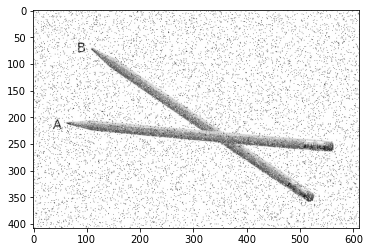

In [2]:
image = cv2.imread('2_pencils.jpg') 
plt.imshow(image, cmap='gray')

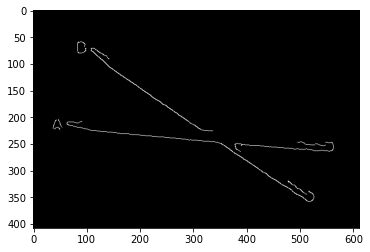

In [3]:
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(image_gray, (15, 15), 0)
edges = cv2.Canny(blur, 50, 150, apertureSize=3)
plt.imshow(edges, cmap='gray')

# Angle Detection by Hough transform

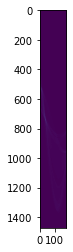

In [4]:
# Set a precision of 1 degree. (Divide into 180 data points)
# You can increase the number of points if needed. 
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)

# Perform Hough Transformation to change x, y, to h, theta, dist space.
hspace, theta, dist = hough_line(edges, tested_angles)
plt.imshow(hspace) 

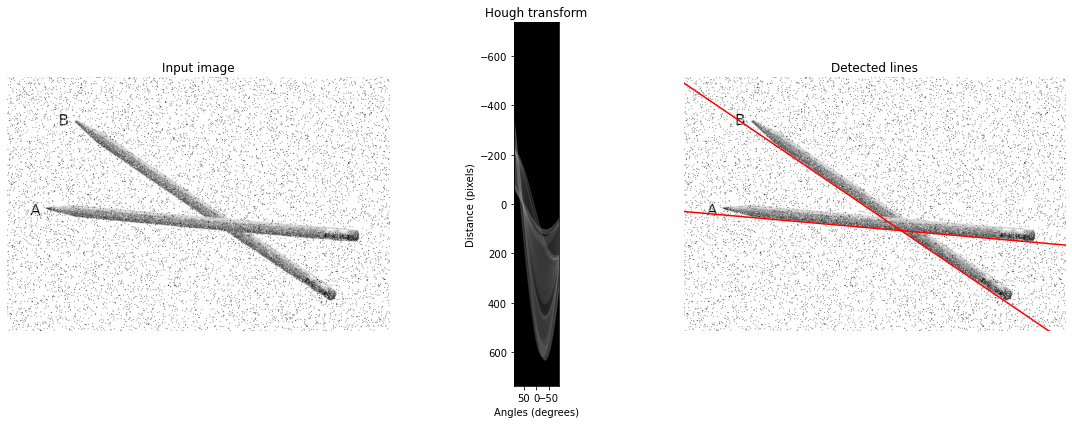

Minimum angle between the pencils: 29.16 degrees
Maximaum angle between the pencils: 150.84 degrees


In [5]:
#Now, to find the location of peaks in the hough space we can use hough_line_peaks
h, q, d = hough_line_peaks(hspace, theta, dist)

angle_list=[]  #Create an empty list to capture all angles

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + hspace),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), dist[-1], dist[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap='gray')

origin = np.array((0, image.shape[1]))

for _, angle, dist in zip(*hough_line_peaks(hspace, theta, dist)):
    angle_list.append(angle) #Not for plotting but later calculation of angles
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

# Convert angles from radians to degrees (1 rad = 180/pi degrees)
angles = [a*180/np.pi for a in angle_list]

# Compute difference between the two lines
angle_difference = np.max(angles) - np.min(angles)
print(f"Minimum angle between the pencils: {angle_difference:.2f} degrees")
print(f"Maximaum angle between the pencils: {180 -angle_difference:.2f} degrees")


#### Minimum angle between the pencils is 29.16,  e,i. approximatly 30 degrees

# Finding the lenght of the Pencil B

C:\Users\Dell\AppData\Local\Temp\ipykernel_17232\2480766491.py:21: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


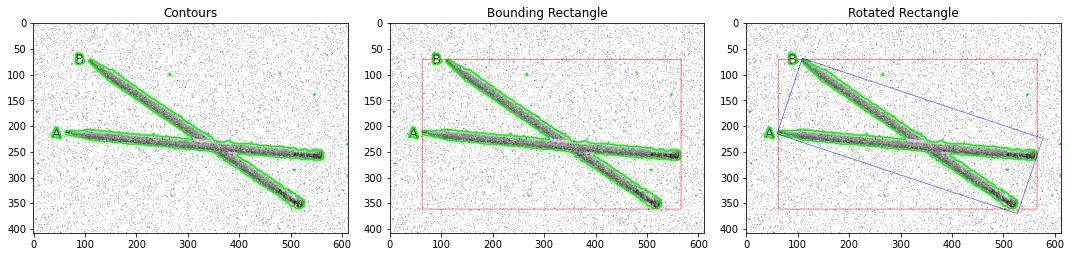

In [6]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

_, mask = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY_INV)
cont,_ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cont_img = cv2.drawContours(image.copy(),cont,-1,(0,255,0),2)
plt.imshow(cont_img,cmap='gray')
# Plot the contour image
axs[0].imshow(cont_img, cmap='gray')
axs[0].set_title('Contours')

c=max(cont, key=cv2.contourArea)
x,y,w,h=cv2.boundingRect(c)
cv2.rectangle(cont_img,(x,y),(x+w,y+h),(255,0,0),1)
# Plot the rectangle
axs[1].imshow(cont_img, cmap='gray')
axs[1].set_title('Bounding Rectangle')

rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(cont_img,[box],0,(0,0,255),1)
# Plot the rotated rectangle
axs[2].imshow(cont_img, cmap='gray')
axs[2].set_title('Rotated Rectangle')

# Adjust spacing between plots
plt.tight_layout()

# Show the figure
plt.show()


In [7]:
blur = cv2.GaussianBlur(image_gray, (9, 9), 0)
edged = cv2.Canny(blur, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# Find contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Sort contours from left to right as leftmost contour is reference object
(cnts, _) = contours.sort_contours(cnts)

# Identify Pencils A and B
# Assuming Pencil A is the smaller one, you may need to adjust this based on your image
pencil_A = cnts[0]
pencil_B = cnts[1]

# Reference object dimensions
ref_box = cv2.minAreaRect(pencil_A)
ref_box = cv2.boxPoints(ref_box)
ref_box = np.array(ref_box, dtype="int")
ref_box = perspective.order_points(ref_box)
(tl, tr, br, bl) = ref_box
dist_in_pixel = euclidean(tl, tr)
dist_in_cm = 2
pixel_per_cm = dist_in_pixel/dist_in_cm

# Calculate Length of Pencil B
box_B = cv2.minAreaRect(pencil_B)
box_B = cv2.boxPoints(box_B)
box_B = np.array(box_B, dtype="int")
box_B = perspective.order_points(box_B)
(tl_B, tr_B, br_B, bl_B) = box_B
length_of_pencil_B = euclidean(tl_B, tr_B) / pixel_per_cm

# Print Length of Pencil B and Angle
print(f"Length of Pencil B: {length_of_pencil_B:.2f} cm")

Length of Pencil B: 5.00 cm


#### Lenght of a Pencil B is 5cm

# **** Thank you ***